# Datasets comparison between CAMS and IASI (L2)

## Imports and supporting functions

In [1]:
# Related to the system
import os 

# Related to the data retrieval
from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt
import cdsapi
import cfgrib
import geojson
import urllib3

# Related to the data analysis
import math
import xarray as xr
import pandas as pd
import numpy as np
import datetime as dt
from itertools import product
import scipy.interpolate
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import cdist

# Related to the results
from copy import copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import geocoder
import seaborn as sns
from matplotlib import animation
from IPython.display import HTML, display
import warnings

In [2]:
%run functions/functions_general.ipynb
%run functions/functions_cams.ipynb
%run functions/functions_iasi.ipynb

In [3]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

# Hide API request warning
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Increase animation limit
matplotlib.rcParams['animation.embed_limit'] = 25000000

# Hide labels animation warning
warnings.filterwarnings('ignore', category = UserWarning, module='cartopy')

## 1. Define datasets

In [4]:
# Define component (CO or O3)
component_nom = 'O3'

# Define model
model = 'cams'
model_full_name = 'cams-global-atmospheric-composition-forecasts'

# Define sensor
sensor = 'iasi'
sensor_type = 'L2'
satellites = ['A', 'B', 'C']
apply_kernels = False

# Define search period
start_date = '2019-05-14'
end_date = '2019-05-15'

# Define extent
lon_min = -180
lon_max = 180
lat_min = -90
lat_max = 90

# Define resolution (Minimum: 1x1)
lat_res = 1
lon_res = 1

In [5]:
# Check if comparison is possible
comparison_check(sensor, model, component_nom, model_full_name, sensor_type)

# Get component full name and molecular weight
component, component_mol_weight, product_type, sensor_column = components_table(sensor, component_nom, sensor_type)

# Folders generation
generate_folders(model, sensor, component_nom, sensor_type)

The comparison is possible and will start now.


In [6]:
# Generate array with search dates
dates = search_period(start_date, end_date, sensor, sensor_type)

# Create bbox
bbox = search_bbox(lon_min, lat_min, lon_max, lat_max)

SEARCH PERIOD
- In days: ('2019-05-14', '2019-05-15')
SEARCH BOUNDING BOX
Latitudes: from -90 to 90
Longitudes: from -180 to 180


## 2. Model data

### Download and read data as xarray

In [7]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, component_nom, 
                                               model_full_name, model_level = 'Single',
                                               CAMS_UID = None, CAMS_key = None)

The file exists, it will not be downloaded again.


In [8]:
model_ds, dates = CAMS_read(model_product_name, component, component_nom, dates)
model_ds

2021-12-11 11:17:36,073 WARNING Ignoring index file '/home/alba/adc-toolbox/data/cams/O3/O3-hourly-tc-2019-05-14-2019-05-15.grib.923a8.idx' incompatible with GRIB file


<xarray.Dataset>
Dimensions:     (latitude: 451, longitude: 900, step: 8, time: 2)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2019-05-14 2019-05-15
  * step        (step) timedelta64[ns] 00:00:00 03:00:00 ... 18:00:00 21:00:00
    surface     float64 ...
  * latitude    (latitude) float64 -90.0 -89.6 -89.2 -88.8 ... 89.2 89.6 90.0
  * longitude   (longitude) float64 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
    valid_time  (time, step) datetime64[ns] ...
Data variables:
    component   (time, step, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-12-11T11:17 GRIB to CDM+CF via cfgrib-0.9.9...

### Collect 137 levels model data

In [9]:
model_levels_df = CAMS_137_levels()
model_levels_df

,a [Pa],b,ph [hPa],pf [hPa],Geopotential Altitude [m],Geometric Altitude [m],Temperature [K],Density [kg/m^3],ph [Pa],ph-diff [Pa],Depth [m]
hybrid,,,,,,,,,,,
1,2.000365,0.000000,0.0200,0.0100,79301.79,80301.65,198.05,0.000018,2.00,2.00,5580.21
2,3.102241,0.000000,0.0310,0.0255,73721.58,74584.91,209.21,0.000042,3.10,1.10,2605.83
3,4.666084,0.000000,0.0467,0.0388,71115.75,71918.79,214.42,0.000063,4.67,1.57,2497.32
4,6.827977,0.000000,0.0683,0.0575,68618.43,69365.77,221.32,0.000090,6.83,2.16,2407.44
5,9.746966,0.000000,0.0975,0.0829,66210.99,66906.53,228.06,0.000127,9.75,2.92,2320.96
...,...,...,...,...,...,...,...,...,...,...,...
133,62.781250,0.988500,1002.2250,1000.5165,106.54,106.54,287.46,1.212498,100222.50,341.69,27.50
134,22.835938,0.991984,1005.3562,1003.7906,79.04,79.04,287.64,1.215710,100535.62,313.12,25.12
135,3.757813,0.995003,1008.2239,1006.7900,53.92,53.92,287.80,1.218650,100822.39,286.77,22.96


### Convert CAMS data units (kg/m2 to molecules/cm<sup>2</sup>)

In [10]:
model_ds, units = model_convert_units(model, model_ds, sensor, 
                                      component_mol_weight, component, model_levels_df,
                                      start_date, end_date, component_nom, apply_kernels,
                                      CAMS_UID = None, CAMS_key = None)

The model component units have been converted from kg m**-2 to molec cm-2.
The model component units have been converted from molec cm-2 to DU.


## 3. Sensor data

### Download and read data as xarray

In [11]:
dates = sensor_download(sensor, sensor_type, component_nom, dates)

RESULTS
For 2019-05-14:
IASI_FORLI_O3_metopa_20190514_v20151001.nc was downloaded.
IASI_FORLI_O3_metopb_20190514_v20151001.nc was downloaded.
IASI_FORLI_O3_metopc_20190514_v20151001.nc is not available.
For 2019-05-15:
IASI_FORLI_O3_metopa_20190515_v20151001.nc was downloaded.
IASI_FORLI_O3_metopb_20190515_v20151001.nc was downloaded.
IASI_FORLI_O3_metopc_20190515_v20151001.nc is not available.


In [12]:
sensor_ds, _, _ = sensor_read(sensor, sensor_type, sensor_column, component_nom, dates, lat_res, lon_res)
sensor_ds

/tmp/ipykernel_861370/432632214.py:70: RuntimeWarning: invalid value encountered in true_divide
  zi = zi / counts
/tmp/ipykernel_861370/432632214.py:70: RuntimeWarning: invalid value encountered in true_divide
  zi = zi / counts


<xarray.DataArray 'sensor_column' (time: 2, latitude: 180, longitude: 360)>
array([[[       nan, 0.12976611,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan, 0.12083906, 0.12430965, ..., 0.1250074 ,
         0.1282189 ,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]])
Coordinates:
  * longitude   (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude    (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    delta_time  (time) datetime64[ns] 2019-05-14 2019-05-15
  * time        (time) datetime64[ns] 2019-05-14 2019-05-15
Attributes:
    units:    mol m-2

### Convert IASI data units (From mol/m<sup>2</sup> to molecules/cm<sup>2</sup>)

In [13]:
sensor_ds = sensor_convert_units(sensor_ds, sensor, component)
sensor_ds

The sensor component units have been converted from mol cm-2 to molec cm-2.
The sensor component units have been converted from molec cm-2 to DU.


<xarray.DataArray 'sensor_column' (time: 2, latitude: 180, longitude: 360)>
array([[[         nan, 290.50916774,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan, 270.52407539, 278.29371843, ..., 279.85578785,
         287.0454243 ,          nan],
        ...,
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        ...,
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]]])
Coordinates:
  * longitude   (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude    (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    delta_time  (time) datetime64[ns] 2019-05-14 2019-05-15
  * time        (time) datetime64[ns] 2019-05-14 2019-05-15
Attributes:
    units:    DU

## 4. Match data

In [14]:
match_df = generate_match_df(sensor_ds, model_ds, bbox, 
                                   sensor, component_nom, apply_kernels)
match_df

FOR DATE: 2019-05-14
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR DATE: 2019-05-15
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.


,latitude,longitude,delta_time,time,sensor_column,step_index,model_column
0,-89.5,-179.5,2019-05-14,2019-05-14,NaN,0,241.387924
1,-89.5,-178.5,2019-05-14,2019-05-14,290.509168,0,241.359802
2,-89.5,-177.5,2019-05-14,2019-05-14,NaN,0,241.341141
3,-89.5,-176.5,2019-05-14,2019-05-14,NaN,0,241.313248
4,-89.5,-175.5,2019-05-14,2019-05-14,NaN,0,241.295929
...,...,...,...,...,...,...,...
64795,89.5,175.5,2019-05-15,2019-05-15,NaN,0,397.204071
64796,89.5,176.5,2019-05-15,2019-05-15,NaN,0,397.221161
64797,89.5,177.5,2019-05-15,2019-05-15,NaN,0,397.273926
64798,89.5,178.5,2019-05-15,2019-05-15,NaN,0,397.309906


## 5. Merge data and calculate difference

In [15]:
merge_df = generate_merge_df(match_df, sensor_ds, model_ds, sensor, apply_kernels)
merge_df

model_column  sensor_column  difference  \
latitude longitude time                                                  
-89.5    -179.5    2019-05-14    241.387924            NaN         NaN   
         -178.5    2019-05-14    241.359802     290.509168   49.149365   
         -177.5    2019-05-14    241.341141            NaN         NaN   
         -176.5    2019-05-14    241.313248            NaN         NaN   
         -175.5    2019-05-14    241.295929            NaN         NaN   
...                                     ...            ...         ...   
 89.5     175.5    2019-05-15    397.204071            NaN         NaN   
          176.5    2019-05-15    397.221161            NaN         NaN   
          177.5    2019-05-15    397.273926            NaN         NaN   
          178.5    2019-05-15    397.309906            NaN         NaN   
          179.5    2019-05-15    397.364807            NaN         NaN   

                               relative_difference  
latitude longitude time                             
-89.5    -179.5    2019-05-14                  NaN  
         -178.5    2019-05-14            -0.169184  
         -177.5    2019-05-14                  NaN  
         -176.5    2019-05-14                  NaN  
         -175.5    2019-05-14                  NaN  
...                                            ...  
 89.5     175.5    2019-05-15                  NaN  
          176.5    2019-05-15                  NaN  
          177.5    2019-05-15                  NaN  
          178.5    2019-05-15                  NaN  
          179.5    2019-05-15                  NaN  

[129600 rows x 4 columns]

In [16]:
descr_statistics_table = merge_df.describe()
descr_statistics_table

,model_column,sensor_column,difference,relative_difference
count,129600.000000,81913.000000,81913.000000,81913.000000
mean,312.201384,308.411051,2.819964,-0.007148
std,60.611397,57.322227,17.080857,0.052324
min,235.361572,198.245303,-106.141990,-0.307550
25%,263.123306,263.574607,-5.354252,-0.029743
50%,287.738556,289.370544,1.110534,-0.003832
75%,356.680077,340.497180,9.331895,0.018752
max,494.159668,585.497307,131.957548,0.396693


## 6. Show comparison plots

### Select plot dates

In [17]:
plot_dates = plot_period(sensor_ds, sensor)

The plots will be shown for the following dates:
['2019-05' '2019-05']


### Select plot extent

In [18]:
plot_bbox = plot_extent(bbox)

The plots will be shown for the following spatial extent: 
((-180, -90), (180, 90))


### Compare CAMS and IASI total columns

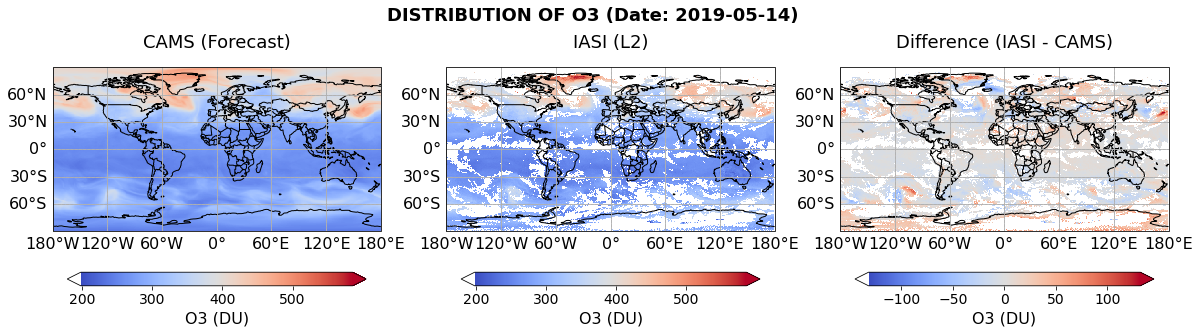

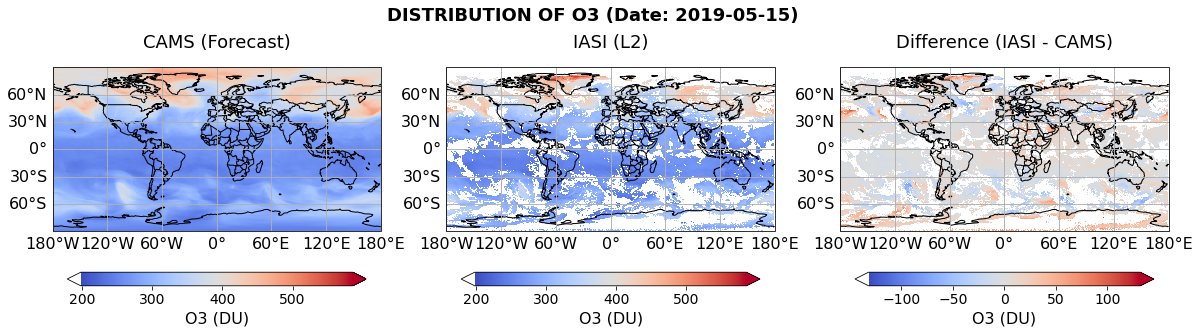

In [19]:
# Choose distribution (aggregated, individual or animated)
distribution_type = 'individual'

# Choose range (original, equal or manual)
range_type = 'equal'
vmin_manual = None
vmax_manual = None

# Define projection and colors
projection = ccrs.PlateCarree()
color_scale =  'coolwarm'

visualize_model_vs_sensor(model, sensor, component_nom, units, merge_df, plot_dates, plot_bbox, 20, 0.9, 
                          model_type, sensor_type, range_type, distribution_type, projection,
                          color_scale, vmin_manual, vmax_manual)

## 7. Retrieve nearest values to specific latitude and longitude

model_column  \
lat_search lon_search latitude longitude time                       
50         15         49.5     14.5      2019-05-14    403.476654   
                      52.5     12.5      2019-05-15    375.473724   
4          10         3.5      9.5       2019-05-14    272.880646   
                                         2019-05-15    266.312561   
20         30         19.5     29.5      2019-05-14    266.535278   
                                         2019-05-15    272.180511   

                                                     sensor_column  \
lat_search lon_search latitude longitude time                        
50         15         49.5     14.5      2019-05-14     437.094993   
                      52.5     12.5      2019-05-15     361.914504   
4          10         3.5      9.5       2019-05-14     268.632217   
                                         2019-05-15     264.735068   
20         30         19.5     29.5      2019-05-14     259.970190   
                                         2019-05-15     293.680749   

                                                     difference  \
lat_search lon_search latitude longitude time                     
50         15         49.5     14.5      2019-05-14   33.618339   
                      52.5     12.5      2019-05-15  -13.559221   
4          10         3.5      9.5       2019-05-14   -4.248428   
                                         2019-05-15   -1.577493   
20         30         19.5     29.5      2019-05-14   -6.565088   
                                         2019-05-15   21.500238   

                                                     relative_difference  
lat_search lon_search latitude longitude time                             
50         15         49.5     14.5      2019-05-14            -0.076913  
                      52.5     12.5      2019-05-15             0.037465  
4          10         3.5      9.5       2019-05-14             0.015815  
                                         2019-05-15             0.005959  
20         30         19.5     29.5      2019-05-14             0.025253  
                                         2019-05-15            -0.073210

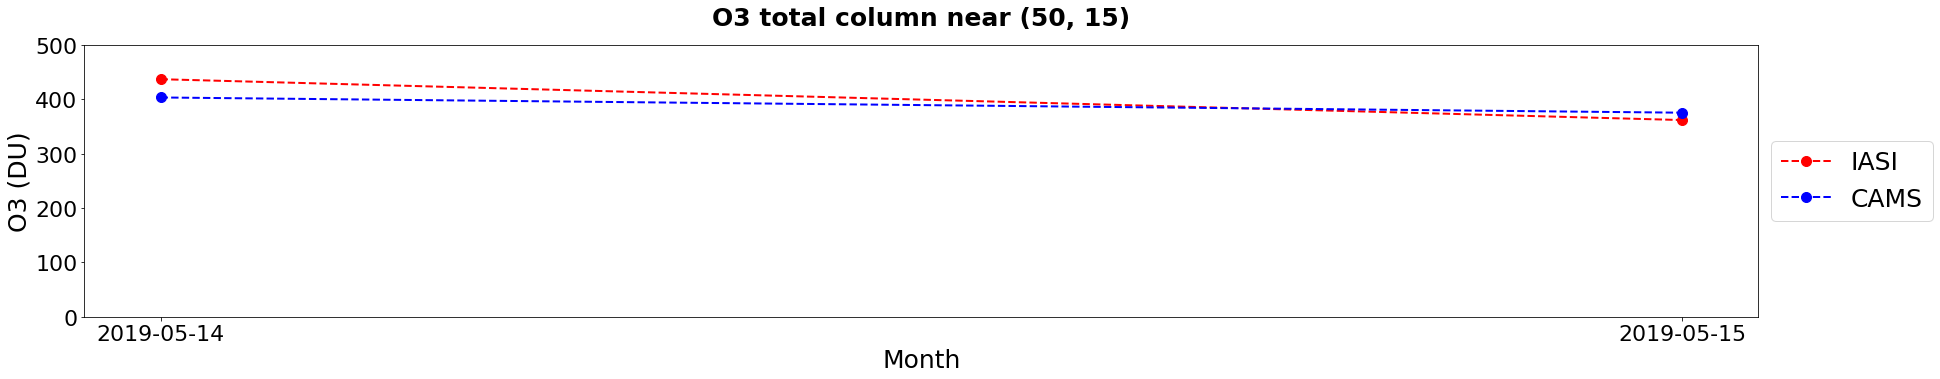

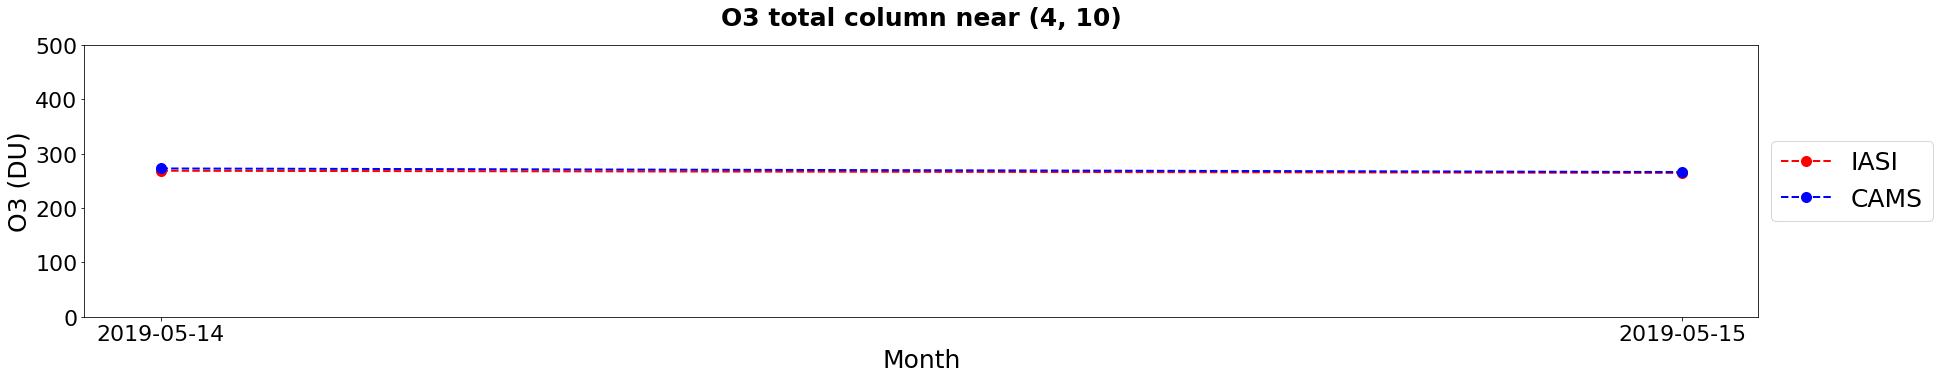

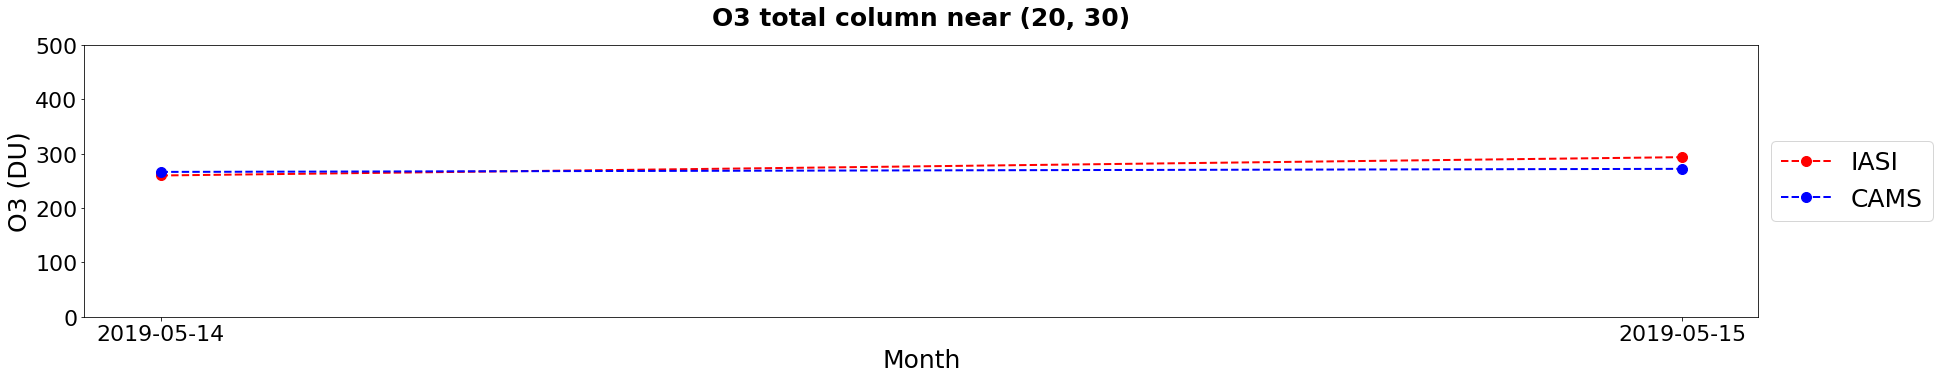

In [20]:
coords_search_list = (50, 15,
                      4, 10,
                      20, 30)
ymin = 0
ymax = 500
xticks = plot_dates
retrieval_table_all =  retrieve_coords(merge_df.dropna(), coords_search_list, component_nom, 
                                       sensor, model, plot_dates, units, ymin, ymax, xticks)
retrieval_table_all

## 8. Scatter plots by bbox

Fit equation: O3_model = O3_sensor * 0.93 + (1.99E+01)
Coefficient of determination (R2): 0.91


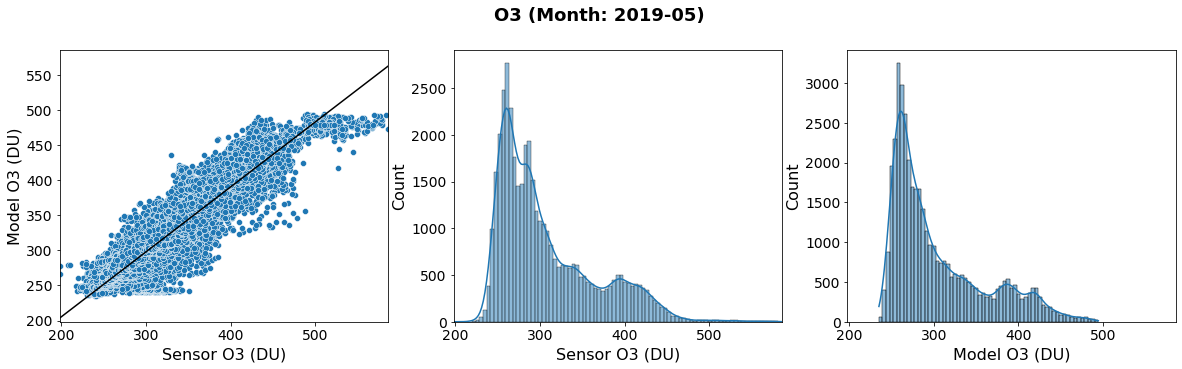

Fit equation: O3_model = O3_sensor * 0.93 + (1.89E+01)
Coefficient of determination (R2): 0.92


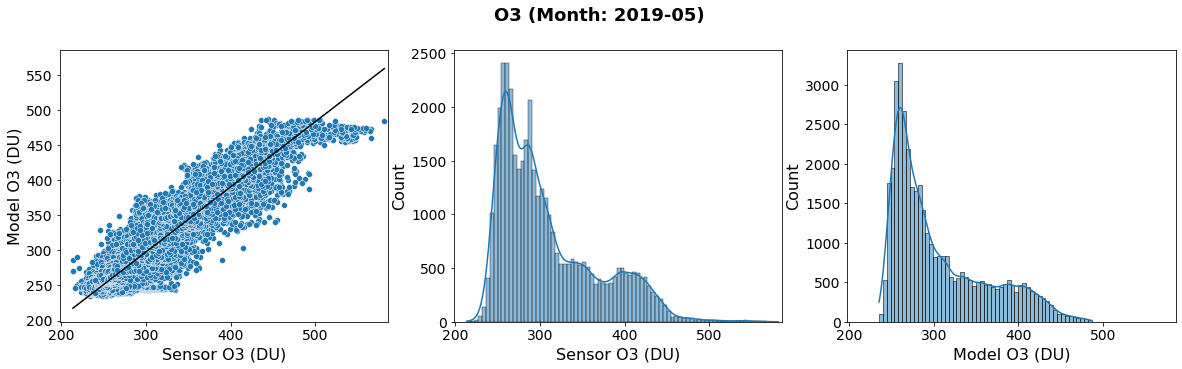

In [21]:
show_seasons = False
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual

lim_min = None
lim_max = None

summary = scatter_plot(merge_df.dropna(), component_nom, units, sensor, plot_dates, 1, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)

In [22]:
summary

,Period,Location,Score,Coefficient,Intercept
0,2019-05-14,"((-180, -90), (180, 90))",0.907984,0.926503,19.923304
1,2019-05-15,"((-180, -90), (180, 90))",0.915055,0.929229,18.926888


## 9. Scatter plots by season

Fit equation: O3_model = O3_sensor * 0.93 + (1.94E+01)
Coefficient of determination (R2): 0.91


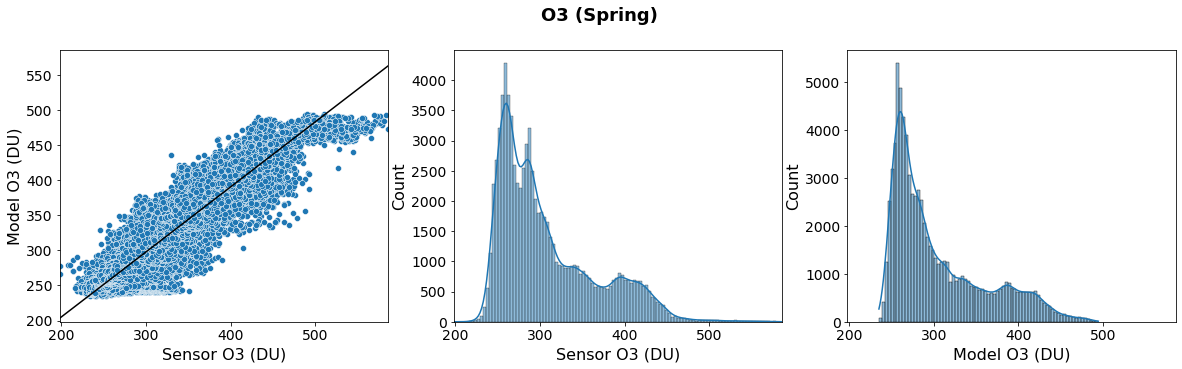

In [23]:
show_seasons = True
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual

lim_min = None
lim_max = None

summary = scatter_plot(merge_df.dropna(), component_nom, units, sensor, plot_dates, 1, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)

In [24]:
summary

,Period,Location,Score,Coefficient,Intercept
0,Spring,"((-180, -90), (180, 90))",0.911501,0.927844,19.433876


## 10. Scatter plots by country (Google API required!)

In [25]:
"""
show_seasons = False
extent_definition = 'country' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual
plot_countries = ['France', 'Germany', 'Italy']

lim_min = None
lim_max = None

summary = scatter_plot(merge_df.dropna(), component_nom, units, sensor, plot_dates, 1, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_countries)
"""

"\nshow_seasons = False\nextent_definition = 'country' # bbox or country\nscatter_plot_type = 'individual' # aggregated or individual\nplot_countries = ['France', 'Germany', 'Italy']\n\nlim_min = None\nlim_max = None\n\nsummary = scatter_plot(merge_df.dropna(), component_nom, units, sensor, plot_dates, 1, \n                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_countries)\n"

In [26]:
#summary